<a href="https://colab.research.google.com/github/Zarhan19/PyTorch---DeepLearning/blob/master/MNIST_Digit_Classification_ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
from torch import nn,optim
import torch.nn.functional as F
import torch.optim as optim

# Is PyTorch using a GPU?
print(torch.cuda.is_available())
# Get the name of the current GPU
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
Tesla P100-PCIE-16GB


In [ ]:
def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4

def load_digit_mnist(batch_size_train,batch_size_test):
# `ToTensor` converts the image data from PIL type to 32-bit floating point
# tensors. It divides all numbers by 255 so that all pixel values are between
# 0 and 1 (i.e. normalizes the data)

  # if resize:
  #       trans.insert(0, transforms.Resize(resize))
  # trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.MNIST(root="../data", train=True,
                                           transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                     torchvision.transforms.Normalize((0.1307,), (0.3081,))]),
                                           download=True)
  mnist_test = torchvision.datasets.MNIST(root="../data", train=False, 
                                           transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                     torchvision.transforms.Normalize((0.1307,), (0.3081,))]), download=True)
  train_iter = data.DataLoader(mnist_train, batch_size_train,shuffle=True,num_workers=get_dataloader_workers())
  test_iter = data.DataLoader(mnist_test, batch_size_test,shuffle=True,num_workers=get_dataloader_workers())
  
  return train_iter,test_iter


SyntaxError: ignored

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1

train_iter,test_iter = load_digit_mnist(batch_size_test,batch_size_train)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)





torch.Size([1000, 1, 28, 28]) torch.float32 torch.Size([1000]) torch.int64


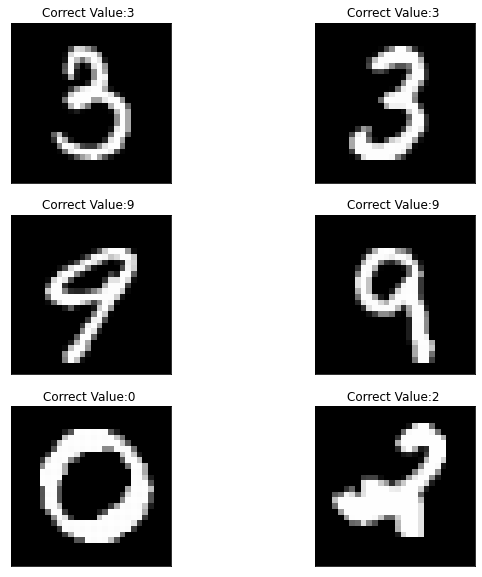

In [ ]:
#Print the details of one batch of train data
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    #show_images(X.reshape(batch_size, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));
    break

## Plot 6 figures from the Train set 
plt.figure(figsize=(10,10))

for i in range(6):
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i][0], cmap='gray', interpolation='none')
    plt.title("Correct Value:{} ".format(y[i]))

# Training Loop description : 


1.   Call the network training function
2.   Iterate over all training data once per epoch.Loading the individual batches is handled by the DataLoader
2.   Manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients

1.   Produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the actual value
2.   The backward() call collects a new set of gradients which we propagate back into each of the network's parameters using optimizer.step()



In [ ]:
# Define the architecture of the network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), ## 1 : greyscale , no.of channels is 1 ; 32: output channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # output of layer 1 = 32 channels of 14 X 14 size
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),## 32 : input channels ; 64: output channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # output of layer 2 = 64 channels of 7 X 7 size
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1) # flattens the output from 7 x 7 x 64 to 3164 x 1 
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

 #initialize the model
model = ConvNet() 
# set the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate,  momentum=momentum) 
# set the loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
total_step = len(train_iter)
loss_list = []
accuracy_list = []

def train(n_epochs):
  for epoch in range(n_epochs):
    for i ,(X, y) in enumerate(train_iter):
      optimizer.zero_grad()
      output = model(X)
      loss = criterion(output,y)
      loss_list.append(loss.item())
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = y.size(0)
      _,predicted = torch.max(output.data, 1)
      correct = (predicted == y).sum().item()
      accuracy_list.append(correct / total)
    
    print('Epoch {}, counter {}'.format(epoch,i))
    if (i + 1) % 10 == 0:
            print('Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, loss.item(),(correct / total) * 100))

train(n_epochs)


Epoch 0, counter 59
Epoch 1, Loss: 0.6997, Accuracy: 80.10%
Epoch 1, counter 59
Epoch 2, Loss: 0.3759, Accuracy: 88.30%
Epoch 2, counter 59
Epoch 3, Loss: 0.3030, Accuracy: 92.00%
Epoch 3, counter 59
Epoch 4, Loss: 0.2545, Accuracy: 93.90%
Epoch 4, counter 59
Epoch 5, Loss: 0.2164, Accuracy: 93.60%


In [ ]:
# Test the model
model.eval() # automatically disables dropout or batch normalization
with torch.no_grad(): #disables autograd functionality
    correct = 0
    total = 0
    for X, y in test_iter:
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))



Test Accuracy of the model on the 10000 test images: 94.78999999999999 %
